## Bag of words model Profession

In [446]:
# Main imports
import pandas as pd
from nltk.corpus import stopwords
from helper import remove_unused_columns, transform_profession, preprocess_text
import matplotlib.pyplot as plt

In [447]:
# reading our files and
file = '../excel-data/all-data-linkedin.csv'
data_csv = pd.read_csv(file)
data_top = remove_unused_columns(data_csv)[0:13]

# Get our columns into lists
headline_categories = list(data_csv['Industry'])
profession = transform_profession(data_top, data=data_csv)
category_list = data_csv['Headline']
category_id = [i for i in range(len(category_list))]

# Initialize our columns into a dataframe
dtf = pd.DataFrame()
dtf['category_id'] = category_id
dtf['categories'] = headline_categories
dtf['profession'] = profession

# Clean your data set first remove unwanted words like: "I", "me", "you"
list_stop_of_words = stopwords.words('english')
dtf['clean_text_profession'] = dtf['profession'].apply(
    lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=list_stop_of_words))

dtf.head()

,category_id,categories,profession,clean_text_profession
0,0,Machine Learning,"Director of Data Science, Machine Learning at ...",director data science machine learning walmart...
1,1,Machine Learning,Machine learning on Encrypted data Engineer,machine learning encrypted data engineer
2,2,Machine Learning,Machine Learning Research Scientist - Deep Lea...,machine learning research scientist deep learning
3,3,Machine Learning,Principal (Manager) R&D Data Scientist,principal manager rd data scientist
4,4,Machine Learning,"Vice President of Machine Learning, Merchandis...",vice president machine learning merchandising ...


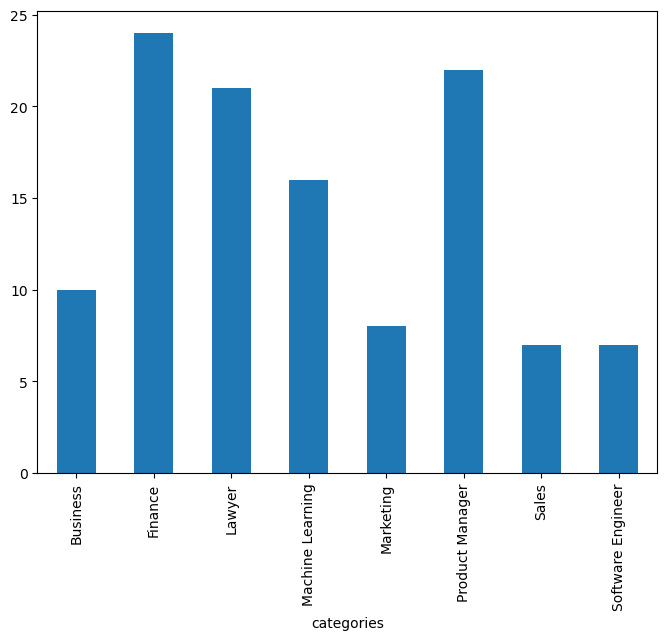

In [448]:
fig = plt.figure(figsize=(8, 6))

dtf.groupby('categories').categories.count().plot.bar(ylim=0)
plt.show()

## Applying Bag-of-Words

In [449]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2),
                        stop_words='english')
features = tfidf.fit_transform(dtf.clean_text_profession).toarray()
labels = dtf.category_id
features.shape

(115, 26)

In [450]:
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
import numpy as np

N = 2
category_id = dict(dtf['category_id'])

for Value, category_id in sorted(category_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Value))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    print("---------------------------------------------------------------------\n")

# '0':
  . Most correlated unigrams:
. machine
. global
  . Most correlated bigrams:
. product manager
. machine learning
---------------------------------------------------------------------

# '1':
  . Most correlated unigrams:
. machine
. engineer
  . Most correlated bigrams:
. product manager
. machine learning
---------------------------------------------------------------------

# '2':
  . Most correlated unigrams:
. scientist
. learning
  . Most correlated bigrams:
. product manager
. machine learning
---------------------------------------------------------------------

# '3':
  . Most correlated unigrams:
. principal
. scientist
  . Most correlated bigrams:
. machine learning
. product manager
---------------------------------------------------------------------

# '4':
  . Most correlated unigrams:
. machine
. president
  . Most correlated bigrams:
. product manager
. machine learning
---------------------------------------------------------------------

# '5':
  . Most corre

In [451]:
# Split our data set
X_train, X_test, y_train, y_test = train_test_split(dtf['clean_text_profession'], dtf['categories'], random_state=0)

# [Training] Naive base classifier

In [452]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics

def vectorize_data(train):
    count_vect_one = CountVectorizer()
    x_train_counts = count_vect_one.fit_transform(train)

    tfidf_transformer = TfidfTransformer()
    x_train_tfidf_one = tfidf_transformer.fit_transform(x_train_counts)
    return x_train_counts, x_train_tfidf_one, count_vect_one

def predict_headline(cl, item):
    return cl.predict(count_vect.transform([item]))[0]

X_train_counts, x_train_tfidf, count_vect = vectorize_data(X_train)

clf = MultinomialNB().fit(x_train_tfidf, y_train)

In [453]:
naive_prediction = clf.predict(count_vect.transform(X_test))

print('----------- F1 Score ----------')
print(metrics.f1_score(y_test, naive_prediction, average='weighted'))
print('\n')

print('----------- Accuracy Score -----------')
print(metrics.accuracy_score(y_test, naive_prediction))
print('\n')

print('----------- Classification Report ----------')
print(metrics.classification_report(y_test, naive_prediction))
print('\n')

print('----------- Confusion Matrix ----------')
print(metrics.confusion_matrix(y_test, naive_prediction))
print('\n')

----------- F1 Score ----------
0.7239852101921067


----------- Accuracy Score -----------
0.7241379310344828


----------- Classification Report ----------
                  precision    recall  f1-score   support

        Business       0.33      1.00      0.50         1
         Finance       0.67      0.57      0.62         7
          Lawyer       0.75      0.50      0.60         6
Machine Learning       1.00      0.83      0.91         6
       Marketing       1.00      0.50      0.67         2
 Product Manager       0.67      1.00      0.80         6
           Sales       1.00      1.00      1.00         1

        accuracy                           0.72        29
       macro avg       0.77      0.77      0.73        29
    weighted avg       0.78      0.72      0.72        29



----------- Confusion Matrix ----------
[[1 0 0 0 0 0 0]
 [1 4 1 0 0 1 0]
 [0 2 3 0 0 1 0]
 [1 0 0 5 0 0 0]
 [0 0 0 0 1 1 0]
 [0 0 0 0 0 6 0]
 [0 0 0 0 0 0 1]]




# [Training] K-Nearest-neighbor

In [454]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=2)

Knn = clf.fit(x_train_tfidf, y_train)
knn_prediction = Knn.predict(count_vect.transform(X_test))

naive_prediction = clf.predict(count_vect.transform(X_test))

print('----------- F1 Score ----------')
print(metrics.f1_score(y_test, knn_prediction, average='weighted'))
print('\n')

print('----------- Accuracy Score -----------')
print(metrics.accuracy_score(y_test, knn_prediction))
print('\n')

print('----------- Classification Report ----------')
print(metrics.classification_report(y_test, knn_prediction))
print('\n')

print('----------- Confusion Matrix ----------')
print(metrics.confusion_matrix(y_test, knn_prediction))
print('\n')

----------- F1 Score ----------
0.7251828631138977


----------- Accuracy Score -----------
0.7241379310344828


----------- Classification Report ----------
                  precision    recall  f1-score   support

        Business       0.25      1.00      0.40         1
         Finance       0.80      0.57      0.67         7
          Lawyer       0.67      0.67      0.67         6
Machine Learning       0.80      0.67      0.73         6
       Marketing       0.67      1.00      0.80         2
 Product Manager       1.00      1.00      1.00         6
           Sales       0.00      0.00      0.00         1

        accuracy                           0.72        29
       macro avg       0.60      0.70      0.61        29
    weighted avg       0.76      0.72      0.73        29



----------- Confusion Matrix ----------
[[1 0 0 0 0 0 0]
 [1 4 2 0 0 0 0]
 [0 1 4 1 0 0 0]
 [2 0 0 4 0 0 0]
 [0 0 0 0 2 0 0]
 [0 0 0 0 0 6 0]
 [0 0 0 0 1 0 0]]




/Users/williamssissoko/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/williamssissoko/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/williamssissoko/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

# [Training] LinearSVC

In [460]:
from sklearn.svm import LinearSVC

clf = LinearSVC()
LSV = clf.fit(x_train_tfidf, y_train)

print(predict_headline(LSV, 'Director of Business Development @Legal Decoder'))

linear_svc_prediction = LSV.predict(count_vect.transform(X_test))


print('----------- F1 Score ----------')
print(metrics.f1_score(y_test, linear_svc_prediction, average='weighted'))
print('\n')

print('----------- Accuracy Score -----------')
print(metrics.accuracy_score(y_test, linear_svc_prediction))
print('\n')

print('----------- Classification Report ----------')
print(metrics.classification_report(y_test, linear_svc_prediction))
print('\n')

print('----------- Confusion Matrix ----------')
print(metrics.confusion_matrix(y_test, linear_svc_prediction))
print('\n')

Sales
----------- F1 Score ----------
0.844305120167189


----------- Accuracy Score -----------
0.8275862068965517


----------- Classification Report ----------
                  precision    recall  f1-score   support

        Business       0.33      1.00      0.50         1
         Finance       1.00      0.71      0.83         7
          Lawyer       0.80      0.67      0.73         6
Machine Learning       1.00      0.83      0.91         6
       Marketing       0.50      1.00      0.67         2
 Product Manager       1.00      1.00      1.00         6
           Sales       1.00      1.00      1.00         1

        accuracy                           0.83        29
       macro avg       0.80      0.89      0.81        29
    weighted avg       0.90      0.83      0.84        29



----------- Confusion Matrix ----------
[[1 0 0 0 0 0 0]
 [1 5 1 0 0 0 0]
 [0 0 4 0 2 0 0]
 [1 0 0 5 0 0 0]
 [0 0 0 0 2 0 0]
 [0 0 0 0 0 6 0]
 [0 0 0 0 0 0 1]]




In [456]:
from sklearn.svm import SVC

clf = SVC()
SV = clf.fit(X_train_counts, y_train)
svc_prediction = SV.predict(count_vect.transform(X_test))

print('----------- F1 Score ----------')
print(metrics.f1_score(y_test, svc_prediction, average='weighted'))
print('\n')

print('----------- Accuracy Score -----------')
print(metrics.accuracy_score(y_test, svc_prediction))
print('\n')

print('----------- Classification Report ----------')
print(metrics.classification_report(y_test, svc_prediction))
print('\n')

print('----------- Confusion Matrix ----------')
print(metrics.confusion_matrix(y_test, svc_prediction))
print('\n')

----------- F1 Score ----------
0.7665139458242907


----------- Accuracy Score -----------
0.7931034482758621


----------- Classification Report ----------
                  precision    recall  f1-score   support

        Business       0.50      1.00      0.67         1
         Finance       0.67      0.57      0.62         7
          Lawyer       0.67      1.00      0.80         6
Machine Learning       1.00      0.83      0.91         6
       Marketing       0.00      0.00      0.00         2
 Product Manager       1.00      1.00      1.00         6
           Sales       1.00      1.00      1.00         1

        accuracy                           0.79        29
       macro avg       0.69      0.77      0.71        29
    weighted avg       0.76      0.79      0.77        29



----------- Confusion Matrix ----------
[[1 0 0 0 0 0 0]
 [1 4 2 0 0 0 0]
 [0 0 6 0 0 0 0]
 [0 0 1 5 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 0 0 0 6 0]
 [0 0 0 0 0 0 1]]




/Users/williamssissoko/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/williamssissoko/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/williamssissoko/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

## [Training] Decision Tree

In [457]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth=20, criterion='gini')

DTree = clf.fit(X_train_counts, y_train)
dtree_prediction = DTree.predict(count_vect.transform(X_test))

print('----------- F1 Score ----------')
print(metrics.f1_score(y_test, dtree_prediction, average='weighted'))
print('\n')

print('----------- Accuracy Score -----------')
print(metrics.accuracy_score(y_test, dtree_prediction))
print('\n')

print('----------- Classification Report ----------')
print(metrics.classification_report(y_test, dtree_prediction))
print('\n')

print('----------- Confusion Matrix ----------')
print(metrics.confusion_matrix(y_test, dtree_prediction))
print('\n')

----------- F1 Score ----------
0.7964770861322585


----------- Accuracy Score -----------
0.7931034482758621


----------- Classification Report ----------
                  precision    recall  f1-score   support

        Business       0.50      1.00      0.67         1
         Finance       1.00      0.57      0.73         7
          Lawyer       0.62      0.83      0.71         6
Machine Learning       1.00      0.83      0.91         6
       Marketing       0.67      1.00      0.80         2
 Product Manager       1.00      1.00      1.00         6
           Sales       0.00      0.00      0.00         1

        accuracy                           0.79        29
       macro avg       0.68      0.75      0.69        29
    weighted avg       0.85      0.79      0.80        29



----------- Confusion Matrix ----------
[[1 0 0 0 0 0 0]
 [0 4 3 0 0 0 0]
 [0 0 5 0 0 0 1]
 [1 0 0 5 0 0 0]
 [0 0 0 0 2 0 0]
 [0 0 0 0 0 6 0]
 [0 0 0 0 1 0 0]]


